# Librerias a utilizar

In [2]:
#Importing all necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, dates
import seaborn as sns 


from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_validate
import xgboost as xg
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.metrics import mean_squared_error

# Importar datasets

In [3]:
df_all_mesos = pd.read_csv('df_all_mesos.csv').set_index('month_year')
df_all_dies = pd.read_csv('df_all_days.csv').set_index('DATE OCC')
df_all_mesos_by_area = pd.read_csv('df_all_mesos_by_area.csv').set_index('month_year')
df_all_days_by_area = pd.read_csv('df_all_days_by_area.csv').set_index('DATE OCC')


df_filtered = pd.read_csv('df_filtered.csv')
df = pd.read_csv('df_crimes.csv')

# FUNCION PARA DIVIDIR TRAIN Y TEST

In [4]:
def split_data(data,X,y,test_size,district):
    idx_train, idx_test = train_test_split(data.index, test_size=test_size, shuffle=False)
    if district == True:
        X_train, y_train = X.loc[idx_train.unique(), :], X.loc[idx_test.unique(), :]
        X_test, y_test = y.loc[idx_train.unique()], y.loc[idx_test.unique()]
    else:
        X_train, y_train = X.loc[idx_train, :], X.loc[idx_test, :]
        X_test, y_test = y.loc[idx_train], y.loc[idx_test]
    
    return X_train, y_train, X_test, y_test

# PREDICT: VERANO 2018

In [5]:
df_all_dies.index = pd.to_datetime(df_all_dies.index)
df_all_days = df_all_dies.loc[df_all_dies.index.year >=2015]
df_all_days = df_all_days[df_all_days.index < '2018-09-01'].copy()
df_all_days = df_all_days.drop(columns=['cos(1,freq=A-DEC)'])

In [6]:
df_all_days

,Agressions,New Years,agressions_lag_1,agressions_lag_2,agressions_lag_3,agressions_lag_4,agressions_week_avg,agressions_biweek_avg,agressions_1_month_avg,agressions_2_month_avg,...,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
DATE OCC,,,,,,,,,,,,,,,,,,,,,
2015-01-01,125.0,1,123.0,118.0,120.0,122.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2015-01-02,5.0,0,8.0,4.0,8.0,3.0,15.857143,63.571429,0.000000,0.000000,...,0.201299,0.979530,0.394356,0.918958,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2015-01-03,4.0,0,7.0,3.0,7.0,1.0,3.857143,5.000000,0.000000,0.000000,...,0.394356,0.918958,0.724793,0.688967,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
2015-01-04,5.0,0,5.0,4.0,8.0,6.0,5.428571,5.714286,16.933333,0.000000,...,0.571268,0.820763,0.937752,0.347305,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2015-01-05,9.0,0,7.0,4.0,5.0,3.0,4.857143,5.214286,5.166667,0.000000,...,0.724793,0.688967,0.998717,-0.050649,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27,6.0,0,7.0,9.0,2.0,2.0,5.857143,7.357143,6.733333,6.683333,...,-0.848644,0.528964,-0.897805,-0.440394,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2018-08-28,10.0,0,9.0,12.0,4.0,3.0,7.285714,7.500000,7.166667,7.016667,...,-0.724793,0.688967,-0.998717,-0.050649,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2018-08-29,10.0,0,8.0,7.0,11.0,8.0,8.428571,8.500000,7.800000,7.383333,...,-0.571268,0.820763,-0.937752,0.347305,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490


In [27]:
X = df_all_days.drop(columns = ['Agressions', 'New Years'])
y = df_all_days['Agressions']
X_train, X_test, y_train, y_test  = split_data(y, X, y, 61,False)

model = xg.XGBRegressor(n_estimators=2000, learning_rate = 0.01, max_depth= 5, subsample = 0.5, colsample_bytree = 0.8, colsample_bylevel = 1, random_state=0) 
model.fit(X_train, y_train) 
xg_pred_train_y = model.predict(X_train) 
xg_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
test['Pred']  = xg_pred_test_y
test['Agressions'] = test.iloc[-4697:].values
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

,Agressions,Pred,Mean model,MAPE,MAPE mean,SMAPE,SMAPE mean,MAE,MAE mean,Metrica nomb,Metrica nomb mean,RMSE,RMSE mean,MSE
DATE OCC,,,,,,,,,,,,,,
2018-07-02,5.0,5.830963,8.934426,27.188884,43.510154,25.758304,39.035963,2.217321,3.140016,50.819672,55.737705,2.884397,4.724782,8.319745
2018-07-03,4.0,7.294376,8.934426,27.188884,43.510154,25.758304,39.035963,2.217321,3.140016,50.819672,55.737705,2.884397,4.724782,8.319745
2018-07-04,12.0,11.542723,8.934426,27.188884,43.510154,25.758304,39.035963,2.217321,3.140016,50.819672,55.737705,2.884397,4.724782,8.319745
2018-07-05,12.0,9.298620,8.934426,27.188884,43.510154,25.758304,39.035963,2.217321,3.140016,50.819672,55.737705,2.884397,4.724782,8.319745
2018-07-06,5.0,8.617816,8.934426,27.188884,43.510154,25.758304,39.035963,2.217321,3.140016,50.819672,55.737705,2.884397,4.724782,8.319745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27,6.0,6.296769,8.934426,27.188884,43.510154,25.758304,39.035963,2.217321,3.140016,50.819672,55.737705,2.884397,4.724782,8.319745
2018-08-28,10.0,7.137698,8.934426,27.188884,43.510154,25.758304,39.035963,2.217321,3.140016,50.819672,55.737705,2.884397,4.724782,8.319745
2018-08-29,10.0,8.556065,8.934426,27.188884,43.510154,25.758304,39.035963,2.217321,3.140016,50.819672,55.737705,2.884397,4.724782,8.319745


In [28]:
train = y_train.to_frame()
train['Pred']  = xg_pred_train_y
d = pd.concat([train.reset_index().set_index(['DATE OCC','Agressions', 'Pred']), test.reset_index().set_index(['DATE OCC','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('DATE OCC')
d = d[-30:]

dies_ver = pd.DataFrame()
dies_ver = d[['Agressions', 'Pred']]
dies_ver = dies_ver.rename(columns={'Pred':'XGBoost'})

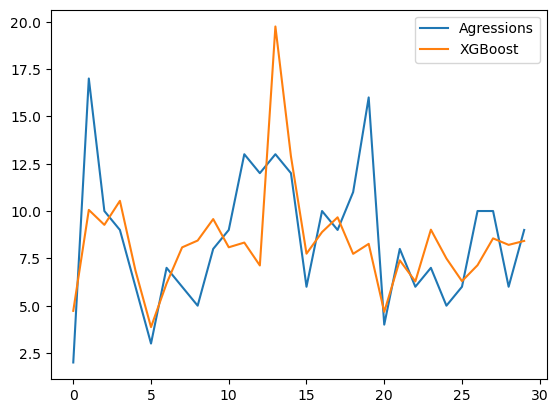

In [29]:
dies_ver = dies_ver.reset_index()
dies_ver.plot(y=["Agressions","XGBoost"])
plt.show()

In [30]:
pred_ver = test[['Agressions', 'Pred']]
pred_ver = pred_ver.rename(columns={'Pred':'XGBoost'})

In [31]:
pred_ver

,Agressions,XGBoost
DATE OCC,,
2018-07-02,5.0,5.830963
2018-07-03,4.0,7.294376
2018-07-04,12.0,11.542723
2018-07-05,12.0,9.298620
2018-07-06,5.0,8.617816
...,...,...
2018-08-27,6.0,6.296769
2018-08-28,10.0,7.137698
2018-08-29,10.0,8.556065


In [33]:
pred_ver.to_csv('pred_models_verano_2018_la.csv')

# PREDICT: VERANO POR COMUNIDAD 2010

# PREDICT: ANY 2010